# CS4248 NLP Project Team 18

## Installing necessary libraries

*Note*: Put libraries that need to be installed with `!pip install LIBRARY` so that we can ensure consistency in packages

In [1]:
!pip install scikit-learn
!pip install pandas
!pip install matplotlib
!pip install tensorflow
!pip install shap
!pip install nltk
!pip install textstat
!pip install textblob


[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


## Constants

Please run this cell. Some constants you are interested in.

In [161]:
import pandas as pd

# Data consists of text (feature) + classification (y value: 1/2/3/4)
TEXT_FEATURE_NAME = "text"
CLASSIFICATION_NAME = "classification"

# CONSTANTS
classifier_mapping = {
    1: "Satire",
    2: "Hoax",
    3: "Propaganda",
    4: "Reliable News"
}
mapping_df = pd.DataFrame(list(classifier_mapping.items()), columns=['classification', 'label'])

## Data Analysis

In [ ]:
import pandas as pd

DATA_FILEPATH = "raw_data/fulltrain.csv"

df = pd.read_csv(DATA_FILEPATH, header=None)
df.head()

### Breakdown of text classifications (Satire / Hoax / Propoganda / Reliable News)

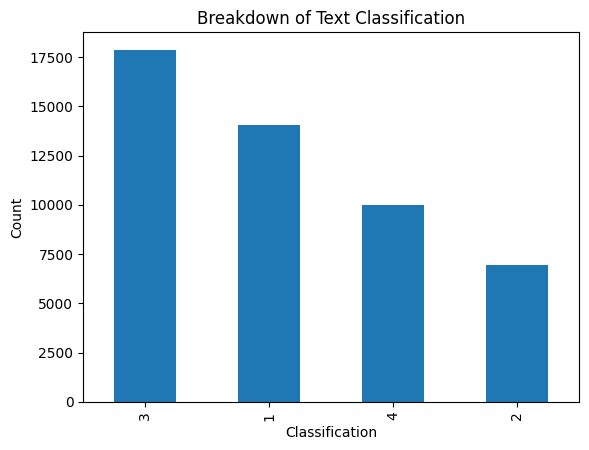

In [3]:
import matplotlib.pyplot as plt

value_counts = df[0].value_counts()
value_counts.plot(kind='bar')
plt.xlabel('Classification')
plt.ylabel('Count')
plt.title('Breakdown of Text Classification')
plt.show()

**Analysis**: We can clearly see that the data is unbalanced. False positive implies that we may classify hoax as reliable news 
and false negatives implies that we may classify reliable news as satire/propaganda/hoax. Depending on the news, our model needs reduce both false negative and false positive. Hence instead of using precision or recall, we will be using macro F1 as the evaluation metric.

### Analysis of features proposed for feature engineering

In this section, we came up with the following features:

- **Readability**

    **Hypothesis**: Hoaxes are used to deceive people. Usually people who do not read critically their sources tend to believe hoaxes, hence language would be simpler to understand. Words may be used more crudely.

    **Actual**: 

- **Token Count**

    **Hypothesis**: Hoaxes tend to be shorter possibly due to shorter attention span. Informative sources tend to be longer due to details that need to be reported

    **Actual**: In reality, this feature may not be useful because the text varies depending on the document. The "text" data can be variable number of sentences, so it is not meaningful to use to differentiate classification. In particular, propaganda have a max count of 130,000+ tokens compared to the rest at max of 2000-5000. Propoganda includes websites as well which may artificially prolong the sentence. Thus, if we wish to use token counts, it needs to be standardise per sentence and websites link need to be handled so they do not artifically bloat up the token count.

- **Polarity**

    **Hypothesis**: Hoaxes are used to deceive people. Usually people who do not read critically their sources tend to believe hoaxes, hence language could be simpler.

    **Actual**: 

- **Subjectivity**

    **Hypothesis**: Hoaxes are used to deceive people. Usually people who do not read critically their sources tend to believe hoaxes, hence language could be simpler.

    **Actual**: 


#### Utility Functions

Please run this cell below before running any of the cells within data analysis

In [47]:
def process_and_add_column(df, process_func, input_col_name, new_col_name):
    selected_col = df[input_col_name]
    new_col = selected_col.apply(process_func)
    df[new_col_name] = new_col

    return df

def calculate_summary_statistics_by_classifier(df, classifier_column, numerical_column):
    aggregations = {
        numerical_column: ['median', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75), 'min', 'max', 'mean']
    }

    summary_stats = df.groupby(classifier_column).agg(aggregations)
    summary_stats.columns = [col[0] + "_" + col[1] for col in summary_stats.columns.values]
    merged_df = pd.merge(summary_stats, mapping_df, on=CLASSIFICATION_NAME)
    
    return merged_df

#### Feature Engineering Creation (raw_data/fulltrain.csv)

In [32]:
import pandas as pd

DATA_FILEPATH = "raw_data/fulltrain.csv"

df = pd.read_csv(DATA_FILEPATH, header=None, names=[CLASSIFICATION_NAME, TEXT_FEATURE_NAME])
df.head()

,classification,text
0,1,"A little less than a decade ago, hockey fans w..."
1,1,The writers of the HBO series The Sopranos too...
2,1,Despite claims from the TV news outlet to offe...
3,1,After receiving 'subpar' service and experienc...
4,1,After watching his beloved Seattle Mariners pr...


In [33]:
# Readablility
import textstat

def calculate_readbility_score(sentence):    
    # Flesch-Kincaid Grade Level
    return textstat.flesch_kincaid_grade(sentence)

new_df = process_and_add_column(df=df, process_func=calculate_readbility_score, input_col_name=TEXT_FEATURE_NAME, new_col_name="readability")
new_df

,classification,text,readability
0,1,"A little less than a decade ago, hockey fans w...",9.1
1,1,The writers of the HBO series The Sopranos too...,12.8
2,1,Despite claims from the TV news outlet to offe...,11.4
3,1,After receiving 'subpar' service and experienc...,11.1
4,1,After watching his beloved Seattle Mariners pr...,12.2
...,...,...,...
48849,4,The ruling Kuomintang (KMT) has claimed owners...,10.6
48850,4,The Taipei city government has encouraged the ...,13.9
48851,4,President Ma Ying-jeou said Friday that a park...,16.3
48852,4,The families of the four people who were kille...,9.4


In [34]:
# Token Count
import textstat
from nltk.tokenize import word_tokenize

def count_tokens(sentence):
    return len(word_tokenize(sentence))

new_df = process_and_add_column(df=df, process_func=count_tokens, input_col_name=TEXT_FEATURE_NAME, new_col_name="word count")
new_df

,classification,text,readability,word count
0,1,"A little less than a decade ago, hockey fans w...",9.1,163
1,1,The writers of the HBO series The Sopranos too...,12.8,135
2,1,Despite claims from the TV news outlet to offe...,11.4,808
3,1,After receiving 'subpar' service and experienc...,11.1,811
4,1,After watching his beloved Seattle Mariners pr...,12.2,207
...,...,...,...,...
48849,4,The ruling Kuomintang (KMT) has claimed owners...,10.6,703
48850,4,The Taipei city government has encouraged the ...,13.9,305
48851,4,President Ma Ying-jeou said Friday that a park...,16.3,453
48852,4,The families of the four people who were kille...,9.4,269


In [35]:
# Polarity
from textblob import TextBlob
def get_polarity(sentence):
    return TextBlob(sentence).sentiment.polarity

new_df = process_and_add_column(df=new_df, process_func=get_polarity, input_col_name=TEXT_FEATURE_NAME, new_col_name="polarity")
new_df

,classification,text,readability,word count,polarity
0,1,"A little less than a decade ago, hockey fans w...",9.1,163,0.193722
1,1,The writers of the HBO series The Sopranos too...,12.8,135,0.087879
2,1,Despite claims from the TV news outlet to offe...,11.4,808,0.075720
3,1,After receiving 'subpar' service and experienc...,11.1,811,0.121929
4,1,After watching his beloved Seattle Mariners pr...,12.2,207,0.157817
...,...,...,...,...,...
48849,4,The ruling Kuomintang (KMT) has claimed owners...,10.6,703,-0.038000
48850,4,The Taipei city government has encouraged the ...,13.9,305,0.077396
48851,4,President Ma Ying-jeou said Friday that a park...,16.3,453,0.074430
48852,4,The families of the four people who were kille...,9.4,269,-0.073457


In [36]:
# Subjectivity
from textblob import TextBlob
def get_subjectivity(sentence):
    return TextBlob(sentence).sentiment.subjectivity

new_df = process_and_add_column(df=new_df, process_func=get_subjectivity, input_col_name=TEXT_FEATURE_NAME, new_col_name="subjectivity")
new_df

,classification,text,readability,word count,polarity,subjectivity
0,1,"A little less than a decade ago, hockey fans w...",9.1,163,0.193722,0.487111
1,1,The writers of the HBO series The Sopranos too...,12.8,135,0.087879,0.327652
2,1,Despite claims from the TV news outlet to offe...,11.4,808,0.075720,0.432300
3,1,After receiving 'subpar' service and experienc...,11.1,811,0.121929,0.433119
4,1,After watching his beloved Seattle Mariners pr...,12.2,207,0.157817,0.585132
...,...,...,...,...,...,...
48849,4,The ruling Kuomintang (KMT) has claimed owners...,10.6,703,-0.038000,0.379000
48850,4,The Taipei city government has encouraged the ...,13.9,305,0.077396,0.480677
48851,4,President Ma Ying-jeou said Friday that a park...,16.3,453,0.074430,0.181448
48852,4,The families of the four people who were kille...,9.4,269,-0.073457,0.348457


In [38]:
# Comment this out if you don't need to overwrite / create balancedfeatures.csv file
# Balanced features.csv file is text + all the additional feature engineering columns.
import os

OUTPUT_FOLDER = "processed_data"
FILE_NAME = "fulltrainfeatures.csv"

if not os.path.exists(OUTPUT_FOLDER):
    os.makedirs(OUTPUT_FOLDER)

file_path = os.path.join(OUTPUT_FOLDER, FILE_NAME)

new_df.to_csv(file_path, index=False)

#### Feature Engineering Analysis (raw_data/fulltrain.csv)

In [39]:
import os
import pandas as pd

OUTPUT_FOLDER = "processed_data"
FILE_NAME = "fulltrainfeatures.csv"
file_path = os.path.join(OUTPUT_FOLDER, FILE_NAME)

if not os.path.exists(file_path):
    raise FileNotFoundError(f"File {file_path} does not exists!")

df = pd.read_csv(file_path)
df

,classification,text,readability,word count,polarity,subjectivity
0,1,"A little less than a decade ago, hockey fans w...",9.1,163,0.193722,0.487111
1,1,The writers of the HBO series The Sopranos too...,12.8,135,0.087879,0.327652
2,1,Despite claims from the TV news outlet to offe...,11.4,808,0.075720,0.432300
3,1,After receiving 'subpar' service and experienc...,11.1,811,0.121929,0.433119
4,1,After watching his beloved Seattle Mariners pr...,12.2,207,0.157817,0.585132
...,...,...,...,...,...,...
48849,4,The ruling Kuomintang (KMT) has claimed owners...,10.6,703,-0.038000,0.379000
48850,4,The Taipei city government has encouraged the ...,13.9,305,0.077396,0.480677
48851,4,President Ma Ying-jeou said Friday that a park...,16.3,453,0.074430,0.181448
48852,4,The families of the four people who were kille...,9.4,269,-0.073457,0.348457


In [48]:
mean_df = calculate_summary_statistics_by_classifier(df, CLASSIFICATION_NAME, "readability")
mean_df.head()

,classification,readability_median,readability_<lambda_0>,readability_<lambda_1>,readability_min,readability_max,readability_mean,label
0,1,11.5,9.2,14.1,-1.2,63.7,11.953478,Satire
1,2,8.5,7.2,9.8,2.1,47.9,8.587093,Hoax
2,3,10.4,8.6,12.3,-3.1,53.3,10.556452,Propaganda
3,4,10.7,8.6,12.7,-3.1,194.8,10.654297,Reliable News


In [50]:
mean_df = calculate_summary_statistics_by_classifier(df, CLASSIFICATION_NAME, "word count")
mean_df.head()

,classification,word count_median,word count_<lambda_0>,word count_<lambda_1>,word count_min,word count_max,word count_mean,label
0,1,184.0,139.00,615.0,2,2465,338.721364,Satire
1,2,207.0,162.00,259.0,2,2654,216.720542,Hoax
2,3,765.0,285.25,1341.0,2,131926,1018.812759,Propaganda
3,4,389.0,219.00,705.0,2,5215,506.043422,Reliable News


In [51]:
mean_df = calculate_summary_statistics_by_classifier(df, CLASSIFICATION_NAME, "polarity")
mean_df.head()

,classification,polarity_median,polarity_<lambda_0>,polarity_<lambda_1>,polarity_min,polarity_max,polarity_mean,label
0,1,0.085707,0.014813,0.152381,-0.8,1.0,0.084869,Satire
1,2,0.044395,-0.032763,0.121446,-1.0,1.0,0.043747,Hoax
2,3,0.064151,0.013889,0.105504,-1.0,1.0,0.064741,Propaganda
3,4,0.070389,0.016441,0.122222,-0.8,0.8,0.070584,Reliable News


In [52]:
mean_df = calculate_summary_statistics_by_classifier(df, CLASSIFICATION_NAME, "subjectivity")
mean_df.head()

,classification,subjectivity_median,subjectivity_<lambda_0>,subjectivity_<lambda_1>,subjectivity_min,subjectivity_max,subjectivity_mean,label
0,1,0.476816,0.416818,0.533346,0.0,1.0,0.473221,Satire
1,2,0.447006,0.377219,0.517568,0.0,1.0,0.448432,Hoax
2,3,0.431018,0.374292,0.476456,0.0,1.0,0.399500,Propaganda
3,4,0.384991,0.316008,0.443910,0.0,1.0,0.372629,Reliable News


## Preprocessing

## Feature Engineering

In [ ]:
import pandas as pd
import textstat
from nltk.tokenize import word_tokenize
from textblob import TextBlob

def normalize(data):
    return (data-data.mean())/data.std()

def count_tokens(sentence):
    return len(word_tokenize(sentence))

def get_polarity(sentence):
    return TextBlob(sentence).sentiment.polarity

def get_subjectivity(sentence):
    return TextBlob(sentence).sentiment.subjectivity

def add_features(data):
    
    # Add features
    token_count = data.apply(lambda x: count_tokens(x))
    readability = data.apply(lambda x: textstat.flesch_reading_ease(x))
    polarity = data.apply(lambda x: get_polarity(x))
    subjectivity = data.apply(lambda x: get_subjectivity(x))
    
    # Normalize features
    token_count = normalize(token_count)
    readability = normalize(readability)
    polarity = normalize(polarity)
    subjectivity = normalize(subjectivity)
    
    return pd.concat([token_count, readability, polarity, subjectivity], axis=1)


train = pd.read_csv('balancedtest.csv', header=None)

x_train = train[train.columns[1]]
y_train = train[train.columns[0]]

train_features = add_features(x_train)

print(train_features)

## Model Training & Evaluation

In [162]:
import pandas as pd
import os

OUTPUT_FOLDER = "preprocessed_data"
FILE_NAME = "preprocessed_fe_train.csv"
file_path = os.path.join(OUTPUT_FOLDER, FILE_NAME)

if not os.path.exists(file_path):
    raise FileNotFoundError(f"File {file_path} does not exists!")

df = pd.read_csv(file_path)
df

,text,classification,readability,subjectivity,polarity,word count
0,little le than decade ago hockey fan were ble...,1,9.1,0.487111,0.193722,163
1,The writer of the HBO series The Sopranos took...,1,12.8,0.327652,0.087879,135
2,Despite claim from the TV news outlet to offer...,1,11.4,0.432300,0.075720,808
3,After receiving subpar service and experiencin...,1,11.1,0.433119,0.121929,811
4,After watching his beloved Seattle Mariners pr...,1,12.2,0.585132,0.157817,207
...,...,...,...,...,...,...
48849,The ruling Kuomintang KMT ha claimed ownership...,4,10.6,0.379000,-0.038000,703
48850,The Taipei city government ha encouraged the r...,4,13.9,0.480677,0.077396,305
48851,President Ma Ying-jeou said Friday that park b...,4,16.3,0.181448,0.074430,453
48852,The family of the four people who were killed ...,4,9.4,0.348457,-0.073457,269


In [163]:
X = df.drop(columns=[CLASSIFICATION_NAME])
y = df[CLASSIFICATION_NAME]
X, y

(                                                    text  readability  \
 0       little le than decade ago hockey fan were ble...          9.1   
 1      The writer of the HBO series The Sopranos took...         12.8   
 2      Despite claim from the TV news outlet to offer...         11.4   
 3      After receiving subpar service and experiencin...         11.1   
 4      After watching his beloved Seattle Mariners pr...         12.2   
 ...                                                  ...          ...   
 48849  The ruling Kuomintang KMT ha claimed ownership...         10.6   
 48850  The Taipei city government ha encouraged the r...         13.9   
 48851  President Ma Ying-jeou said Friday that park b...         16.3   
 48852  The family of the four people who were killed ...          9.4   
 48853  The Ministry of Finance will make public on Sa...          7.5   
 
        subjectivity  polarity  word count  
 0          0.487111  0.193722         163  
 1          0.327652

In [44]:
#TODO: remove this once feature engineering is up
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

max_features = 5000

vectorizer = TfidfVectorizer(max_features=max_features, ngram_range=(1,3))
# Solution to np.str_ to convert invalid document characters to string from this post:
# https://stackoverflow.com/questions/39303912/tfidfvectorizer-in-scikit-learn-valueerror-np-nan-is-an-invalid-document
tfidf_matrix = vectorizer.fit_transform(X[TEXT_FEATURE_NAME].apply(lambda x: np.str_(x)))
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df

,000,000 people,10,10 000,10 year,100,11,12,13,14,...,your,your own,youre,yourself,youth,youtube,youve,yuan,zero,zone
0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.067415,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.156228,0.0,0.0,0.0,0.052157,0.0,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.048272,0.0,0.0,0.0,0.000000,0.0,0.033184,0.00000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48849,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.02597,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
48850,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
48851,0.025499,0.0,0.025998,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.046798,0.0,0.0,0.0,0.0,0.0
48852,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [45]:
# Add in all the feature engineering features (active choice to put '_' at back of features not from vectorizer to differentiate)
tfidf_df['readability_'] = X['readability']
tfidf_df['word count_'] = X['word count']
tfidf_df['subjectivity_'] = X['subjectivity']
tfidf_df['polarity_'] = X['polarity']

tfidf_df

,000,000 people,10,10 000,10 year,100,11,12,13,14,...,youth,youtube,youve,yuan,zero,zone,readability_,word count_,subjectivity_,polarity_
0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,...,0.000000,0.0,0.0,0.0,0.0,0.0,9.1,163,0.487111,0.193722
1,0.000000,0.0,0.067415,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,...,0.000000,0.0,0.0,0.0,0.0,0.0,12.8,135,0.327652,0.087879
2,0.000000,0.0,0.156228,0.0,0.0,0.0,0.052157,0.0,0.000000,0.00000,...,0.000000,0.0,0.0,0.0,0.0,0.0,11.4,808,0.432300,0.075720
3,0.000000,0.0,0.048272,0.0,0.0,0.0,0.000000,0.0,0.033184,0.00000,...,0.000000,0.0,0.0,0.0,0.0,0.0,11.1,811,0.433119,0.121929
4,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,...,0.000000,0.0,0.0,0.0,0.0,0.0,12.2,207,0.585132,0.157817
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48849,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.02597,...,0.000000,0.0,0.0,0.0,0.0,0.0,10.6,703,0.379000,-0.038000
48850,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,...,0.000000,0.0,0.0,0.0,0.0,0.0,13.9,305,0.480677,0.077396
48851,0.025499,0.0,0.025998,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,...,0.046798,0.0,0.0,0.0,0.0,0.0,16.3,453,0.181448,0.074430
48852,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,...,0.000000,0.0,0.0,0.0,0.0,0.0,9.4,269,0.348457,-0.073457


In [46]:
import os

# Squeeze to between 0 and 1
def normalise(col):
    minimum = col.min()
    maximum = col.max()
    return (col - minimum) / (maximum - minimum)

normalised_df = tfidf_df.apply(normalise)
normalised_df.to_csv(os.path.join("preprocessed_data", "normalised_fulltrain.csv"), index=False)

##  Reading the Data (No need care about above if we already have normalised data)

In [164]:
import pandas as pd

normalised_df = pd.read_csv('preprocessed_data/normalised_fulltrain.csv')
X = normalised_df.drop(columns=[CLASSIFICATION_NAME])
y = normalised_df[CLASSIFICATION_NAME]

In [15]:
X

,000,000 people,10,10 000,10 year,100,11,12,13,14,...,youth,youtube,youve,yuan,zero,zone,readability_,word count_,subjectivity_,polarity_
0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.061647,0.001220,0.487111,0.596861
1,0.000000,0.0,0.097965,0.0,0.0,0.0,0.000000,0.0,0.00000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.080344,0.001008,0.327652,0.543939
2,0.000000,0.0,0.227022,0.0,0.0,0.0,0.061645,0.0,0.00000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.073269,0.006110,0.432300,0.537860
3,0.000000,0.0,0.070147,0.0,0.0,0.0,0.000000,0.0,0.08108,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.071753,0.006132,0.433119,0.560964
4,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.077312,0.001554,0.585132,0.578909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48849,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00000,0.051973,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.069227,0.005314,0.379000,0.481000
48850,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.085902,0.002297,0.480677,0.538698
48851,0.037581,0.0,0.037779,0.0,0.0,0.0,0.000000,0.0,0.00000,0.000000,...,0.047842,0.0,0.0,0.0,0.0,0.0,0.098029,0.003419,0.181448,0.537215
48852,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.063163,0.002024,0.348457,0.463272


In [16]:
y

0        1
1        1
2        1
3        1
4        1
        ..
48849    4
48850    4
48851    4
48852    4
48853    4
Name: classification, Length: 48854, dtype: int64

## Settings for train test split

In [165]:
## Settings

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

## Note: Change this to fit the algorithm below
# X are the features
X = X
# y are the outputs
y = y
# test_size is the size of the test (0 < test_size < 1)
test_size = 0.2
# seed for random split
seed = 40
## End of Note

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

### Logistic Regression

#### Running Model

In [166]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

evaluation_metrics = [("Accuracy", accuracy_score), ("Confusion Matrix", confusion_matrix)]

for evaluation_metric_name, evaluation_metric_func in evaluation_metrics:
    print(f"{evaluation_metric_name}:\n{evaluation_metric_func(y_test, y_pred)}")
print(f"F1 Macro Score: {f1_score(y_test, y_pred, average='macro')}")

Accuracy:
0.9713437723876778
Confusion Matrix:
[[2679    9   45   42]
 [  15 1369   37    7]
 [  13   10 3514   20]
 [  41    3   38 1929]]
F1 Macro Score: 0.9702647156328439


#### Saving Coefficients

In [25]:
## PLEASE REMEMBER TO RUN THE "CONSTANTS" CELL (USES classifier_mapping)
import os
import pandas as pd

OUTPUT_FOLDER = "results"
model_name = "logistic_regression"
if not os.path.exists(OUTPUT_FOLDER):
    os.makedirs(OUTPUT_FOLDER)
    
for i in range(4):
    class_name = classifier_mapping[i + 1]
    filename = f"{model_name}_{class_name}.csv"
    coefficients = model.coef_[i]
    coefficients_df = pd.DataFrame({'Features': X_train.columns, 'Coefficient': coefficients})
    coefficients_df['coefficient magnitude'] = abs(coefficients_df['Coefficient'])
    coefficients_df = coefficients_df.sort_values(by='coefficient magnitude', ascending=False)
    coefficients_df.to_csv(os.path.join(OUTPUT_FOLDER, filename), index=False)

### Multinomial Naive Bayes

In [26]:
# For Feature engineering peeps, X cannot contain negative values for multinomial NB. 
# Must either clip or shift and scale the value to get rid of negative values!

from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

evaluation_metrics = [("Accuracy", accuracy_score), ("Confusion Matrix", confusion_matrix)]

for evaluation_metric_name, evaluation_metric_func in evaluation_metrics:
    print(f"{evaluation_metric_name}:\n{evaluation_metric_func(y_test, y_pred)}")
print(f"F1 Macro Score: {f1_score(y_test, y_pred, average='macro')}")

Accuracy:
0.9035922628185447
Confusion Matrix:
[[2518   20   85  152]
 [  65 1315   37   11]
 [  97   53 3336   71]
 [ 270    6   75 1660]]
F1 Macro Score: 0.900712396685067


In [32]:
OUTPUT_FOLDER = "results"
model_name = "multinomial_nb"
if not os.path.exists(OUTPUT_FOLDER):
    os.makedirs(OUTPUT_FOLDER)
    
for i, class_label in enumerate(model.classes_):
    class_name = classifier_mapping[i + 1]
    filename = f"{model_name}_{class_name}.csv"
    feature_log_probabilities = model.feature_log_prob_[i]
    feature_importances_df = pd.DataFrame({'Features': X_train.columns, 'Log Probability': feature_log_probabilities})
    feature_importances_df['probability magnitude'] = abs(feature_importances_df['Log Probability'])
    feature_importances_df = feature_importances_df.sort_values(by='probability magnitude', ascending=False)
    feature_importances_df.to_csv(os.path.join(OUTPUT_FOLDER, filename), index=False)


### CNN

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(image_height, image_width, num_channels)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(units=128, activation='relu'),
    Dense(units=num_classes, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=32)
loss, accuracy = model.evaluate(X_test, y_test)


### RNN

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical

X_train_array = X_train.to_numpy()
X_test_array = X_test.to_numpy()
y_train_encoded = to_categorical(y_train - 1, num_classes=4)
y_test_encoded = to_categorical(y_test- 1, num_classes=4)

num_samples, num_features = X_train_array.shape
timesteps = 1  # You may need to adjust this depending on your data

X_train_reshaped = X_train_array.reshape(num_samples, timesteps, num_features)
X_test_reshaped = X_test_array.reshape(X_test_array.shape[0], timesteps, X_test_array.shape[1])


# create model here
model = tf.keras.Sequential()
model.add(SimpleRNN(units=64, input_shape=(timesteps, num_features)))
Dropout(rate=0.3),
model.add(Dense(units=4, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train_reshaped, y_train_encoded, epochs=5, batch_size=8)
loss, accuracy = model.evaluate(X_test_reshaped, y_test_encoded)

In [ ]:
y_pred = model.predict(X_test_reshaped)
y_labels = np.argmax(y_pred, axis=1) + 1

evaluation_metrics = [("Accuracy", accuracy_score), ("Confusion Matrix", confusion_matrix)]

for evaluation_metric_name, evaluation_metric_func in evaluation_metrics:
    print(f"{evaluation_metric_name}:\n{evaluation_metric_func(y_test, y_labels)}")
f1_score(y_test, y_labels, average="macro")

### LSTM

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import LSTM, Dense, Embedding


X_train_array = X_train.to_numpy()
X_test_array = X_test.to_numpy()
y_train_encoded = to_categorical(y_train - 1, num_classes=4)
y_test_encoded = to_categorical(y_test- 1, num_classes=4)

num_samples, num_features = X_train_array.shape
timesteps = 1  # You may need to adjust this depending on your data

X_train_reshaped = X_train_array.reshape(num_samples, timesteps, num_features)
X_test_reshaped = X_test_array.reshape(X_test_array.shape[0], timesteps, X_test_array.shape[1])


# create model here
model = tf.keras.Sequential()
model.add(LSTM(units=64, implementation=2, dropout=0.2, recurrent_dropout=0.2))  # Disable CuDNN
model.add(Dense(units=4, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train_reshaped, y_train_encoded, epochs=5, batch_size=8)
loss, accuracy = model.evaluate(X_test_reshaped, y_test_encoded)

y_pred = model.predict(X_test_reshaped)
y_labels = np.argmax(y_pred, axis=1) + 1

evaluation_metrics = [("Accuracy", accuracy_score), ("Confusion Matrix", confusion_matrix)]

for evaluation_metric_name, evaluation_metric_func in evaluation_metrics:
    print(f"{evaluation_metric_name}:\n{evaluation_metric_func(y_test, y_labels)}")
print(f"F1 Macro Score: {f1_score(y_test, y_labels, average='macro')}")



## SHAP VALUES (ABANDONED)

Not possible X_train[0:50] already not enough memory space

In [167]:
sp_df = X_test[0:2]

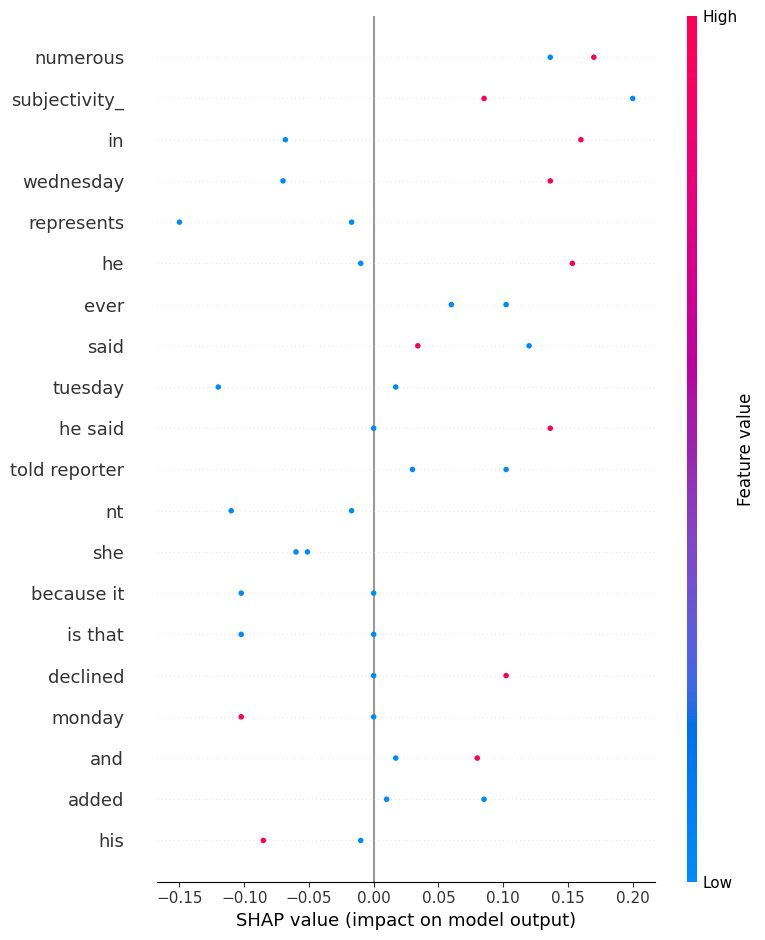

In [171]:
import shap
explainer = shap.Explainer(model.predict, X_train[0:2])
shap_values = explainer.shap_values(sp_df)
shap.summary_plot(shap_values, sp_df)